# Binance Trade Data Analysis

This notebook demonstrates how to analyze the trade data stored in Redis using our custom TradeDataClient.

In [112]:
import sys
sys.path.append('..')

from tradinglib.redis_client import TradeDataClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import DBSCAN

# Scale price data
from sklearn.preprocessing import MinMaxScaler

# Set up plotting style
plt.style.use('seaborn')
sns.set_palette('husl')

/tmp/ipykernel_557419/3967738103.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [113]:
# Initialize the client
client = TradeDataClient()

# Get available symbols
symbols = client.get_available_symbols()
print(f"Available symbols: {symbols}")

Available symbols: ['USDCUSDT', 'NTRNUSDT', 'NKNUSDT', 'RSRUSDT', 'XLMUSDT', 'STGUSDT', 'CELRUSDT', 'SUIUSDT', '1000FLOKIUSDT', 'BTCUSDC', 'TONUSDT', 'LINAUSDT', 'RPLUSDT', 'AVAUSDT', 'PIXELUSDT', 'XTZUSDT', 'AEROUSDT', 'BSWUSDT', '1000RATSUSDT', 'AXLUSDT', 'ONDOUSDT', 'GASUSDT', 'OMUSDT', 'NEIROETHUSDT', 'SLERFUSDT', 'ACHUSDT', 'FIOUSDT', 'COMPUSDT', 'ETHFIUSDT', 'YFIUSDT', '1000CHEEMSUSDT', 'VIRTUALUSDT', 'BTCDOMUSDT', 'MEWUSDT', 'GOATUSDT', 'ETHWUSDT', 'SUIUSDC', 'ETHUSDT_250328', 'ZILUSDT', 'TRUUSDT', 'ALPHAUSDT', 'JOEUSDT', 'REZUSDT', 'ALTUSDT', 'YGGUSDT', 'ETHUSDT_241227', 'SPELLUSDT', 'SCRUSDT', 'WLDUSDT', 'NFPUSDT', 'AXSUSDT', 'COSUSDT', '1000PEPEUSDT', 'KAVAUSDT', 'KNCUSDT', 'ONTUSDT', 'REIUSDT', 'BOMEUSDT', 'KSMUSDT', 'JUPUSDT', 'TRBUSDT', 'LOKAUSDT', 'LITUSDT', 'MEMEUSDT', 'MOVRUSDT', 'GUSDT', 'GMTUSDT', 'ETHUSDC', 'GMXUSDT', 'HFTUSDT', 'XMRUSDT', 'WLDUSDC', 'ILVUSDT', 'INJUSDT', 'CTSIUSDT', 'AKTUSDT', 'GLMUSDT', 'PONKEUSDT', 'ARPAUSDT', 'MOODENGUSDT', 'ADAUSDT', 'SANDUSDT',

## 1. Basic Price Analysis

Let's analyze the price movement for a symbol

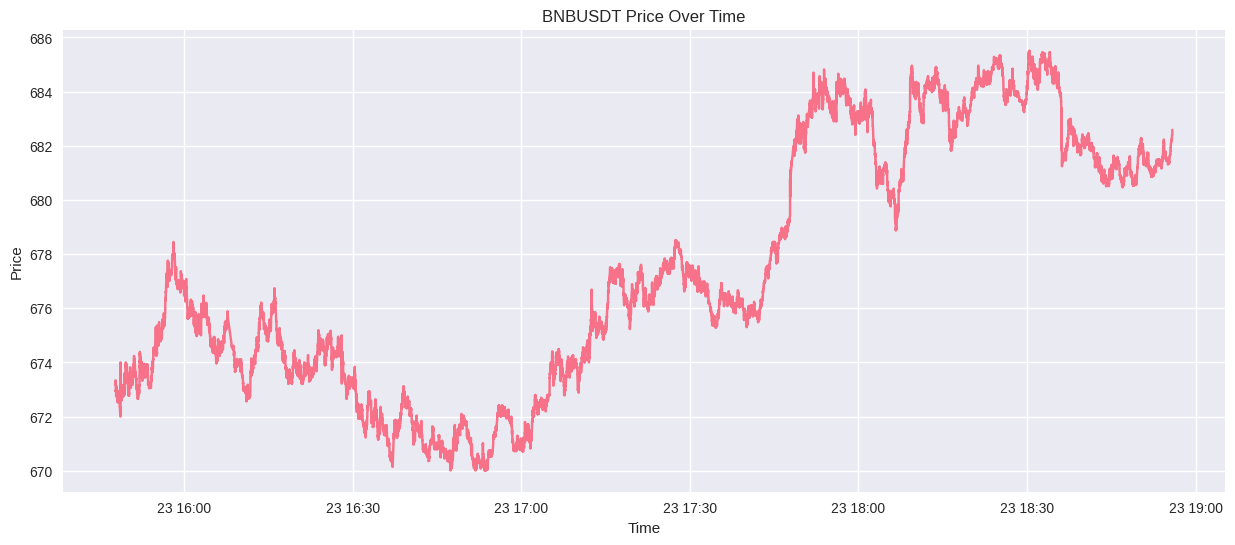

In [114]:
# Choose first available symbol
symbol = 'BNBUSDT'

# Get price data
df = client.get_trade_history(symbol)

# Plot price over time
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['price'])
plt.title(f'{symbol.upper()} Price Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## 2. Volume Analysis

/tmp/ipykernel_557419/1467048974.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  volume_profile = df.groupby(price_bins)['quantity'].sum()


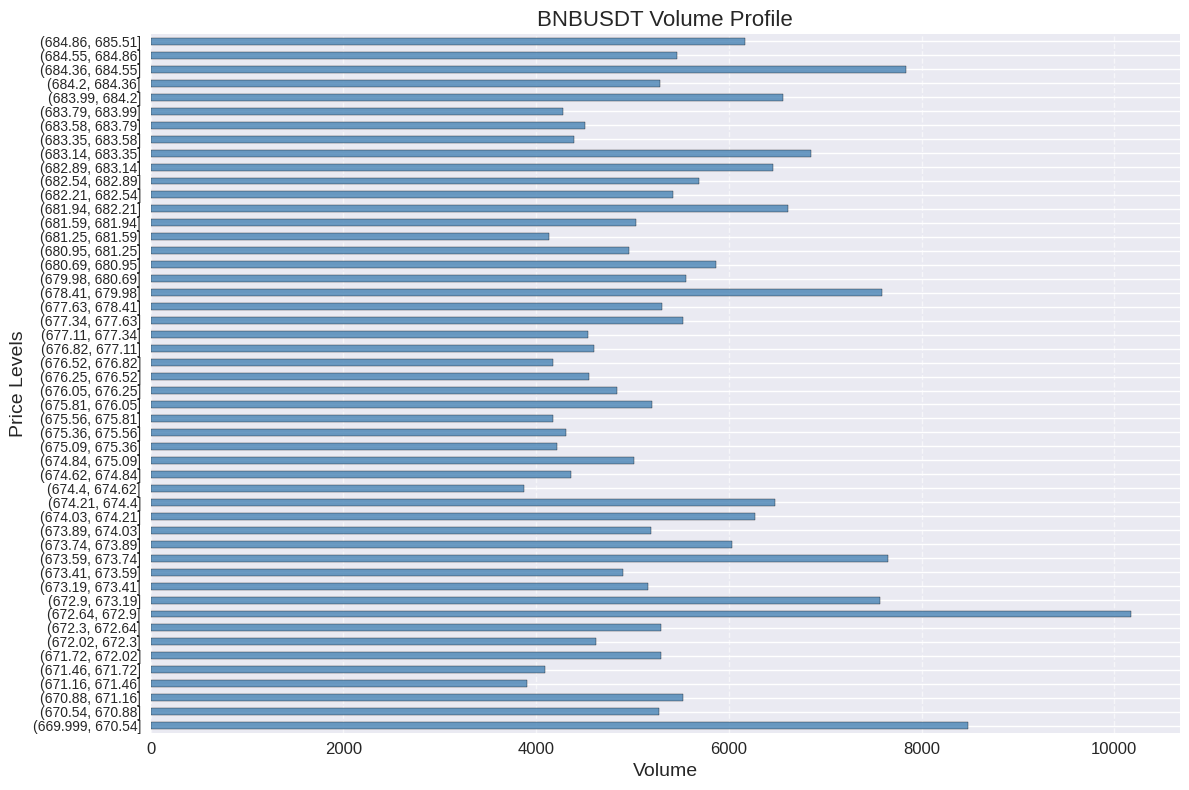

In [115]:

# Fix the FutureWarning by setting observed explicitly
price_bins = pd.qcut(df['price'], q=50, duplicates='drop')  # Adjust bins for better distribution
volume_profile = df.groupby(price_bins)['quantity'].sum()

# Plot volume profile
plt.figure(figsize=(12, 8))
volume_profile.plot(kind='barh', color='steelblue', edgecolor='black', alpha=0.8)
plt.title(f"{symbol.upper()} Volume Profile", fontsize=16)
plt.xlabel("Volume", fontsize=14)
plt.ylabel("Price Levels", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10, rotation=0)  # Ensure labels are horizontal
plt.tight_layout()
plt.show()

/tmp/ipykernel_557419/1715441844.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trade_count_profile = df.groupby(price_bins).size()  # Use .size() to count occurrences


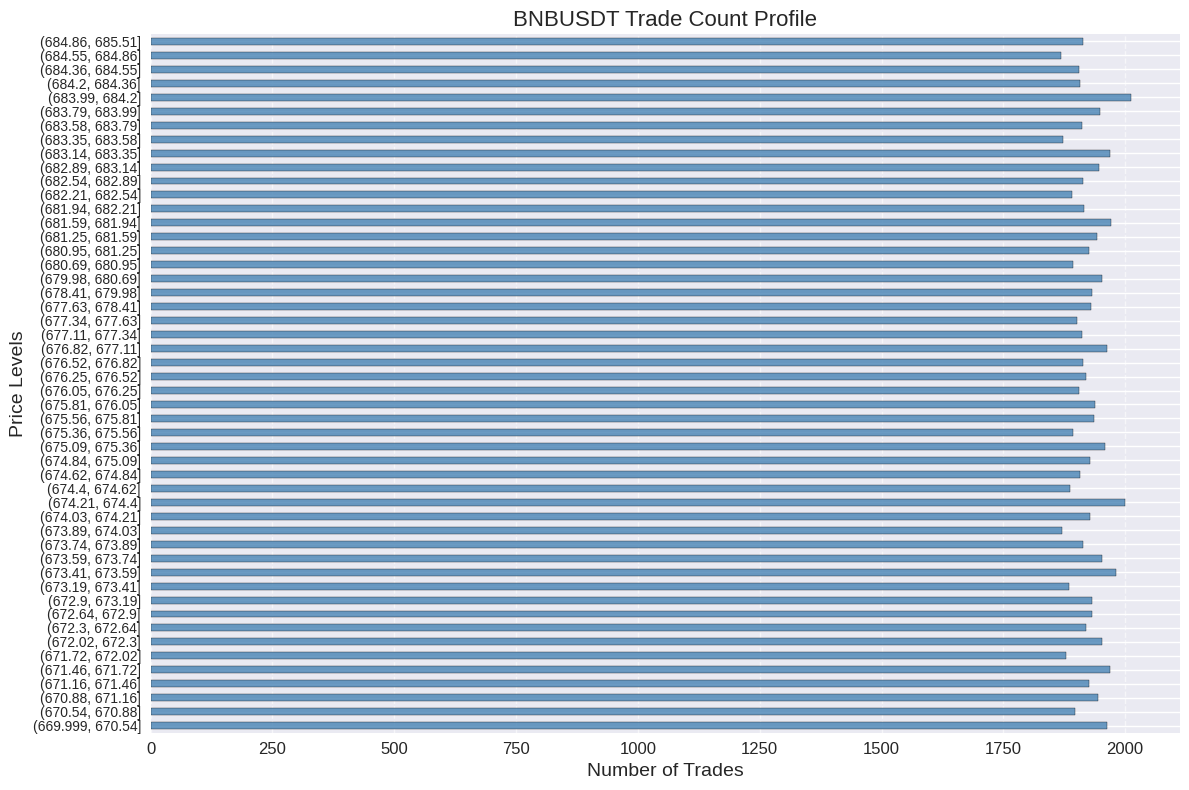

In [116]:
# Calculate the number of trades in each price bin
trade_count_profile = df.groupby(price_bins).size()  # Use .size() to count occurrences

# Plot the volume profile based on the number of trades
plt.figure(figsize=(12, 8))
trade_count_profile.plot(kind='barh', color='steelblue', edgecolor='black', alpha=0.8)
plt.title(f"{symbol.upper()} Trade Count Profile", fontsize=16)
plt.xlabel("Number of Trades", fontsize=14)
plt.ylabel("Price Levels", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=10, rotation=0)  # Ensure labels are horizontal
plt.tight_layout()
plt.show()

## 3. Trade Size Distribution

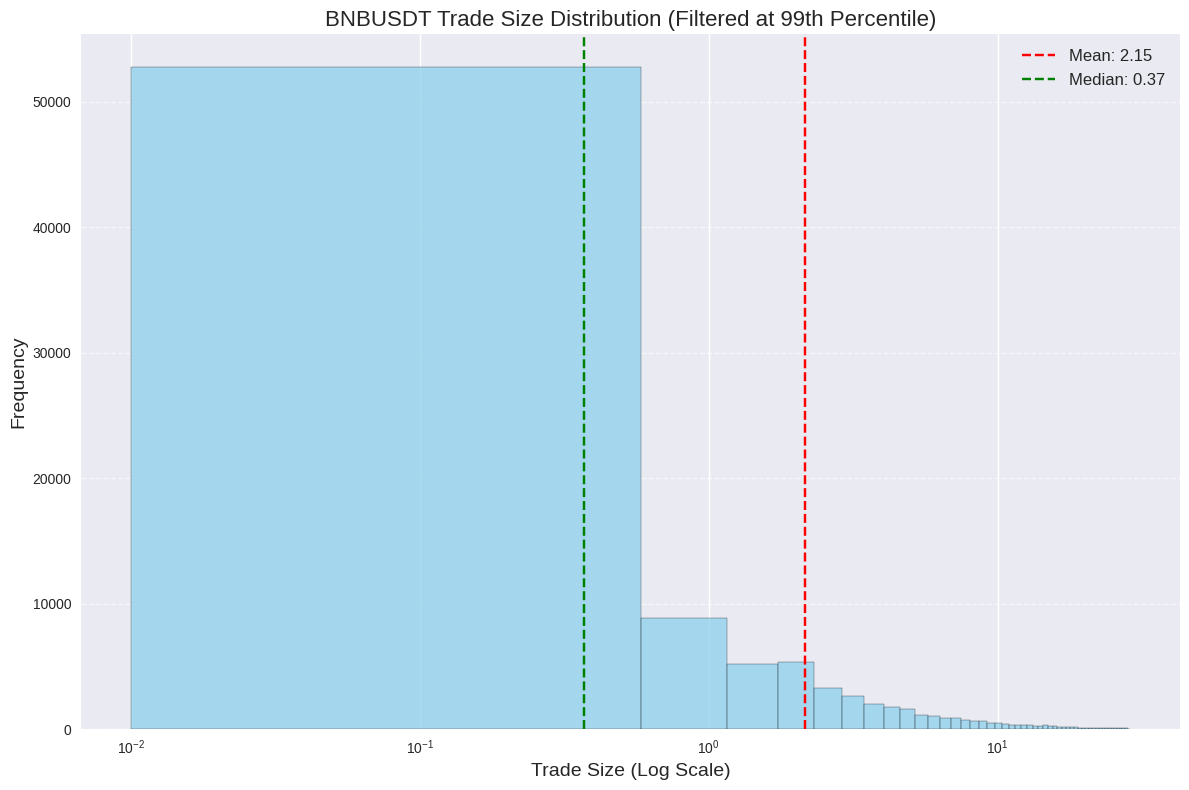


Enhanced Trade Size Statistics (Filtered at 99th Percentile):
count    95359.000000
mean         2.149332
std          4.094528
min          0.010000
25%          0.030000
50%          0.370000
75%          2.230000
99%         21.032600
max         28.760000
Name: quantity, dtype: float64


In [117]:
# Filter out outliers for better visualization (e.g., 99th percentile)
upper_limit = np.percentile(df['quantity'], 99)
filtered_data = df['quantity'][df['quantity'] <= upper_limit]

# Plot histogram with logarithmic scale
plt.figure(figsize=(12, 8))
plt.hist(filtered_data, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"{symbol.upper()} Trade Size Distribution (Filtered at 99th Percentile)", fontsize=16)
plt.xlabel("Trade Size (Log Scale)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xscale('log')  # Apply logarithmic scaling to the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add vertical lines for mean and median
mean = filtered_data.mean()
median = filtered_data.median()
plt.axvline(mean, color='red', linestyle='--', label=f"Mean: {mean:.2f}")
plt.axvline(median, color='green', linestyle='--', label=f"Median: {median:.2f}")
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

# Print enhanced summary statistics
print("\nEnhanced Trade Size Statistics (Filtered at 99th Percentile):")
print(filtered_data.describe(percentiles=[0.25, 0.5, 0.75, 0.99]))

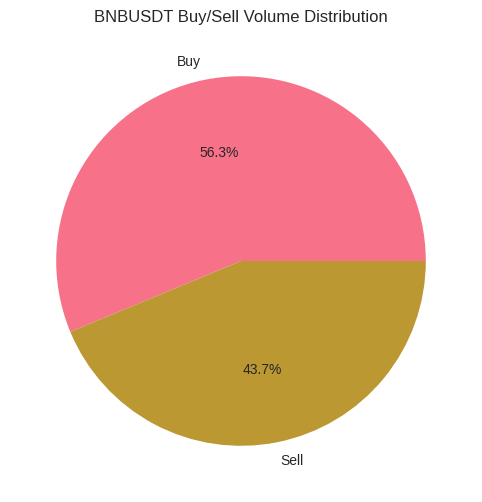


Volume by Trade Type:
trade_type
Buy     1.049324e+08
Sell    8.157375e+07
Name: volume, dtype: float64
Trade Imbalance Index: 12.52%


In [118]:
# Analyze buy/sell pressure
df['trade_type'] = df['is_buyer_maker'].map({True: 'Sell', False: 'Buy'})
df['volume'] = df['price'] * df['quantity']

# Calculate volume by trade type
volume_by_type = df.groupby('trade_type')['volume'].sum()

# Plot pie chart
plt.figure(figsize=(10, 6))
plt.pie(volume_by_type, labels=volume_by_type.index, autopct='%1.1f%%')
plt.title(f'{symbol.upper()} Buy/Sell Volume Distribution')
plt.show()

# Print volume statistics
print("\nVolume by Trade Type:")
print(volume_by_type)

trade_imbalance = (volume_by_type['Buy'] - volume_by_type['Sell']) / volume_by_type.sum() * 100
print(f"Trade Imbalance Index: {trade_imbalance:.2f}%")

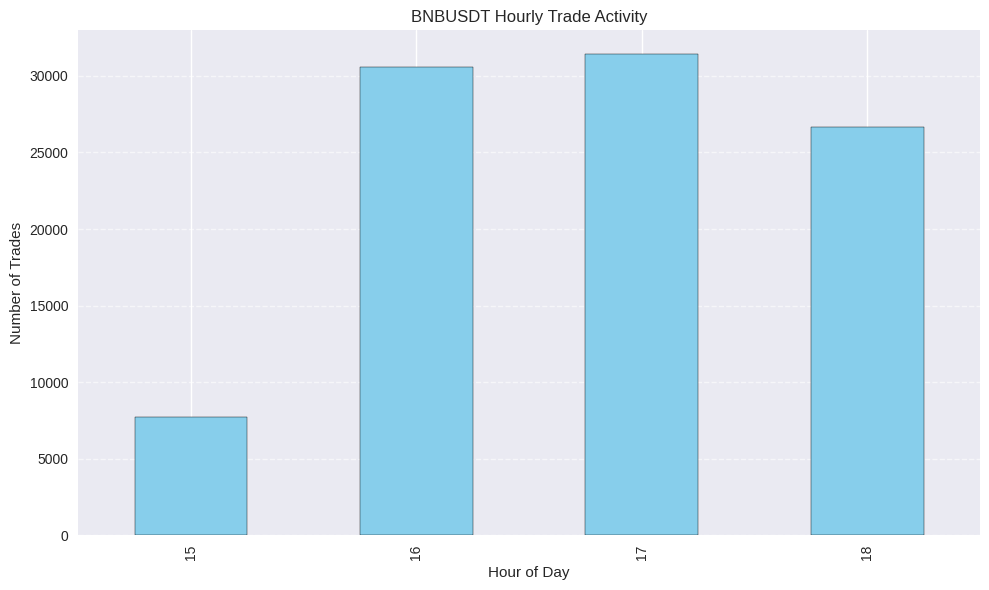

In [119]:
df['hour'] = df.index.hour
hourly_trade_counts = df.groupby('hour').size()

plt.figure(figsize=(10, 6))
hourly_trade_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title(f"{symbol.upper()} Hourly Trade Activity")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Trades")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

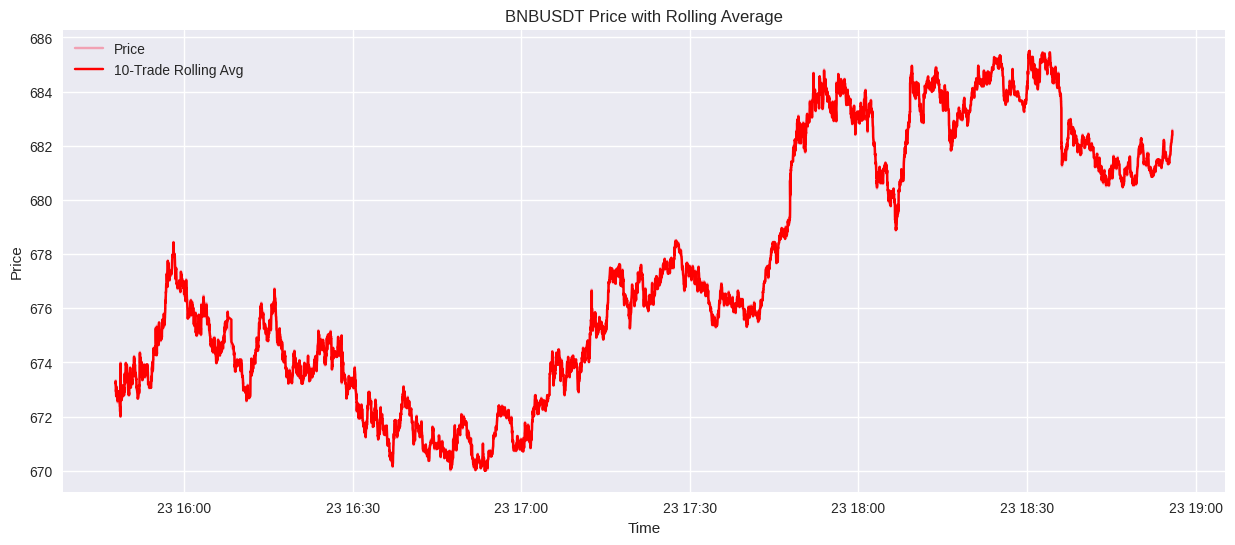

In [120]:
df['rolling_avg_price'] = df['price'].rolling(window=10).mean()
plt.figure(figsize=(15, 6))
plt.plot(df['price'], label='Price', alpha=0.6)
plt.plot(df['rolling_avg_price'], label='10-Trade Rolling Avg', color='red')
plt.title(f"{symbol.upper()} Price with Rolling Average")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

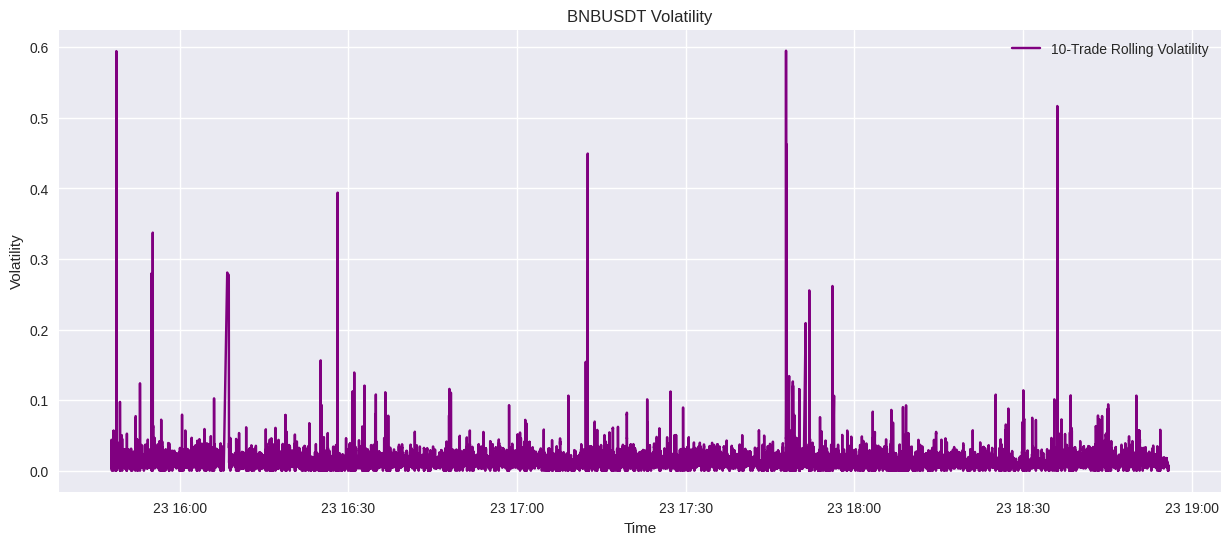

In [121]:
df['price_diff'] = df['price'].diff()
df['volatility'] = df['price_diff'].rolling(window=10).std()

plt.figure(figsize=(15, 6))
plt.plot(df['volatility'], label='10-Trade Rolling Volatility', color='purple')
plt.title(f'{symbol.upper()} Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.grid(True)
plt.legend()
plt.show()

In [122]:
other_symbol = 'BTCUSDT'
other_df = client.get_trade_history(other_symbol)

combined = pd.DataFrame({
    symbol: df['price'].resample('1T').mean(),
    other_symbol: other_df['price'].resample('1T').mean()
}).dropna()

correlation = combined.corr().iloc[0, 1]
print(f"Correlation between {symbol} and {other_symbol}: {correlation:.2f}")


Correlation between BNBUSDT and BTCUSDT: 0.29


In [123]:
df['price_change'] = df['price'].diff()
buy_impact = df.loc[df['trade_type'] == 'Buy', 'price_change'].mean()
sell_impact = df.loc[df['trade_type'] == 'Sell', 'price_change'].mean()

print(f"Average Price Impact - Buy: {buy_impact:.2f}, Sell: {sell_impact:.2f}")

Average Price Impact - Buy: 0.01, Sell: -0.01


In [124]:
scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(df[['price']])

clustering = DBSCAN(eps=0.05, min_samples=10).fit(price_scaled)
df['cluster'] = clustering.labels_

print(df.groupby('cluster').size())

cluster
0    96323
dtype: int64
